In [1]:
%load_ext autoreload
%autoreload 2

# Import all required modules and configuration
from io_utils import process_perp_futures_data, save_optData, save_dataset_dict
from config import *
from data_utils import (
    align_time_series_fast, GroupMinMaxScaler, pivot_features_and_costs,
    split_train_test_by_time_quantile, print_memory, truncate_outliers, 
    compute_technical_features, truncate_target_variable, save_model_parameters,
    process_and_combine_shared
)
from model_factory import build_market_neutral_model, build_market_neutral_model_testing
import pandas as pd
import numpy as np
import os
import gc

# Explicitly import optimization parameters from config
from config import (
    N, RISK_ABS, SINGLE_ABS, L1_ABS, SIGMA_ABS, TURNOVER,
    TRUNCATION_THRESHOLD, TRAIN_TEST_SPLIT_RATIO,
    get_constraint_matrices, get_covariance_matrix, get_risk_factor
)
os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")

print("✅ 所有模块和参数导入完成")
print(f"优化参数: N={N}, RISK_ABS={RISK_ABS}, SINGLE_ABS={SINGLE_ABS}")
print(f"           L1_ABS={L1_ABS}, SIGMA_ABS={SIGMA_ABS}, TURNOVER={TURNOVER}")

Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
✅ 所有模块和参数导入完成
优化参数: N=13, RISK_ABS=1.5, SINGLE_ABS=0.1
           L1_ABS=1.0, SIGMA_ABS=2.5, TURNOVER=0.5


=== 开始数据处理流程 ===
数据文件夹存在: /scratch/gpfs/sl3965/datasets/perp_futures_klines
找到 341 个 parquet 文件
正在读取数据文件...


只读取前7个symbol文件:   0%|          | 0/7 [00:00<?, ?it/s]

合并所有数据...
数据预览:
            open_time     open     high      low    close    volume  count  \
0 2025-01-01 00:00:00  0.19955  0.19959  0.19916  0.19959  140561.0    259   
1 2025-01-01 00:01:00  0.19960  0.19986  0.19952  0.19986   50449.0    146   
2 2025-01-01 00:02:00  0.19988  0.20033  0.19986  0.20033   89781.0    170   
3 2025-01-01 00:03:00  0.20037  0.20077  0.20037  0.20052  509099.0    477   
4 2025-01-01 00:04:00  0.20052  0.20095  0.20052  0.20074  166762.0    256   

    symbol  
0  GRTUSDT  
1  GRTUSDT  
2  GRTUSDT  
3  GRTUSDT  
4  GRTUSDT  

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917280 entries, 0 to 917279
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   open_time  917280 non-null  datetime64[ns]
 1   open       917280 non-null  float64       
 2   high       917280 non-null  float64       
 3   low        917280 non-null  float64       
 4   close      917280 non-null 

/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io_utils.py:134: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sl3965/zyh/my-pyepo/my-PyEPO/00_portfolio_real_data/io

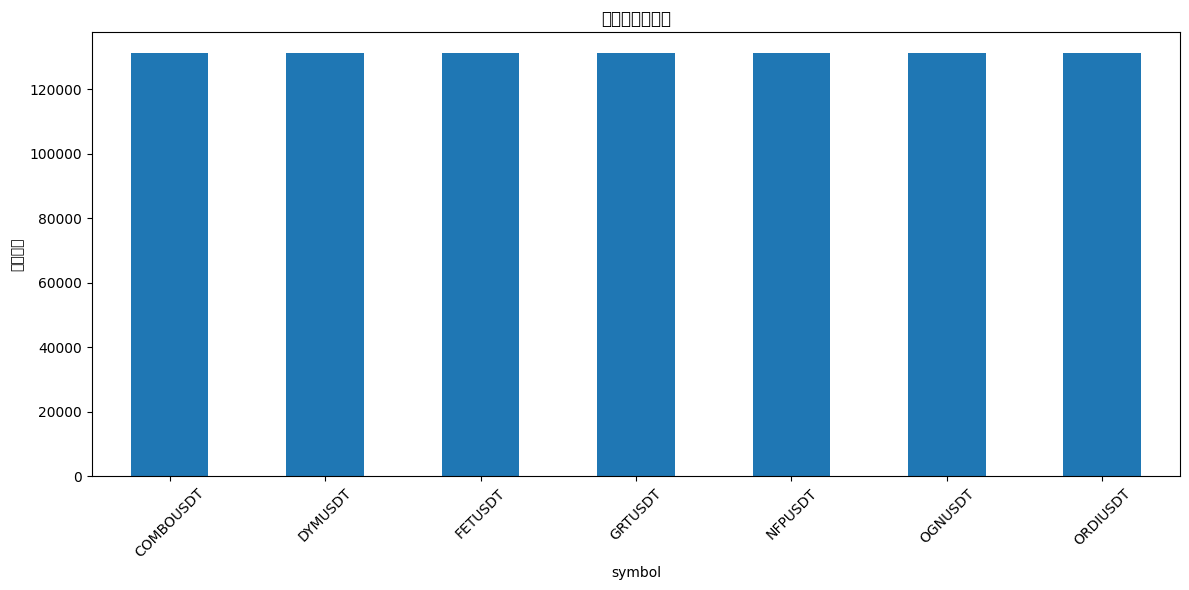


特征统计信息:
                open           high            low          close  \
count  917070.000000  917070.000000  917070.000000  917070.000000   
mean        2.506209       2.508892       2.503487       2.506185   
std         5.811707       5.817487       5.805858       5.811653   
min         0.052400       0.053000       0.052300       0.052400   
25%         0.116100       0.116253       0.116000       0.116100   
50%         0.298700       0.299000       0.298500       0.298700   
75%         0.798400       0.799400       0.797400       0.798400   
max        30.373000      30.399000      30.204000      30.373000   

             volume          count  
count  9.170700e+05  917070.000000  
mean   5.041740e+04     204.959139  
std    1.385716e+05     390.452960  
min    0.000000e+00       0.000000  
25%    4.262700e+03      33.000000  
50%    1.632005e+04      86.000000  
75%    5.121975e+04     238.000000  
max    1.253997e+07   23905.000000  

目标变量统计信息:
count    917070.000000
me

1.1608238220214844

In [2]:
# Data Processing Pipeline
print("=== 开始数据处理流程 ===")

# Step 1: Process raw data
combined_df = process_perp_futures_data(data_path=RAW_DATA_PATH, output_path=PROCESSED_DATA_PATH)
print_memory("加载数据后")

# Step 2: Align time series
aligned_df = align_time_series_fast(combined_df)
print_memory("时间对齐后")

# Step 3: Data cleaning and feature engineering
print("\n开始数据清理和特征工程...")
aligned_df = truncate_outliers(aligned_df, truncation_thres=TRUNCATION_THRESHOLD, group_by_column='symbol')
print_memory("outlier truncation后")

aligned_df = compute_technical_features(aligned_df, group_by_column='symbol')
print_memory("计算技术指标特征后")

aligned_df = truncate_target_variable(aligned_df, target_col=Y_COL, 
                                    truncation_thres=TRUNCATION_THRESHOLD, group_by_column='symbol')
print_memory("Y_COL truncation后")

# Step 4: Save processed data
aligned_df.to_parquet(ALIGNED_CRYPTO_DATA_PATH)
print("时间对齐后的数据信息：")
print(f"Shape: {aligned_df.shape}")
print(aligned_df.head())

# Step 5: Train/Test split
train_df, test_df = split_train_test_by_time_quantile(aligned_df, time_col='open_time', frac=TRAIN_TEST_SPLIT_RATIO)
print(f"Train 时间范围: {train_df['open_time'].min()} — {train_df['open_time'].max()}")
print(f"Test  时间范围: {test_df['open_time'].min()} — {test_df['open_time'].max()}")

# Clean up memory
del combined_df, aligned_df
gc.collect()
print_memory("数据处理完成")

In [3]:
# Training Data Processing and Model Parameter Setup
print("=== 训练数据处理和模型参数设置 ===")

# Step 1: Scale training data
scaler = GroupMinMaxScaler(feature_range=(-1,1), target_columns=X_COLS, group_by_column='symbol')
print("对训练集做scale")
train_df = scaler.fit_transform(train_df)
print_memory("scale train_df 后")

# Step 2: Pivot and save training data
print("pivot features and costs")
features, costs, unique_times, unique_symbols = pivot_features_and_costs(train_df, y_col=Y_COL, x_cols=X_COLS)
save_optData(features, costs, unique_times, unique_symbols, X_COLS, name=OPTDATA_NAME, save_dir=TRAIN_OPTDATA_DIR)
print_memory("pivot train_df 后")

del train_df
gc.collect()
print_memory("删除train_df后") 

# Step 3: Update global N and save model parameters
N = features.shape[1] 
print(f"更新资产数量: N = {N}")

# Save model parameters using config + data_utils functions
A, b, l, u, risk_f, cov_matrix = save_model_parameters(N, costs, save_regular=True, save_testing=True)

# Validate model creation
try:
    model = build_market_neutral_model(N, A, b, l, u, risk_f, RISK_ABS, SINGLE_ABS, L1_ABS, cov_matrix, SIGMA_ABS)
    print("✅ 常规模型创建成功")
except Exception as e:
    print(f"❌ 常规模型创建失败: {e}")

try:
    model_testing = build_market_neutral_model_testing(N, A, b, l, u, risk_f, RISK_ABS, SINGLE_ABS, L1_ABS, cov_matrix, SIGMA_ABS, TURNOVER)
    print("✅ 测试模型创建成功")
except Exception as e:
    print(f"❌ 测试模型创建失败: {e}")

# Step 4: Process test data
test_df = scaler.transform(test_df)
test_features, test_costs, _, _ = pivot_features_and_costs(test_df, y_col=Y_COL, x_cols=X_COLS)
os.makedirs(TEST_DATA_DIR, exist_ok=True)
np.save(f"{TEST_DATA_DIR}/features_{OPTDATA_NAME}.npy", test_features)

del test_df
gc.collect()
print_memory("测试数据处理完成") 

=== 训练数据处理和模型参数设置 ===
对训练集做scale
 scale train_df 后: 1.28 GB
pivot features and costs
Data shape: features (104808, 7, 21), costs (104808, 7)
Data saved to ./train_data with name 'crypto_data'
 pivot train_df 后: 1.42 GB
 删除train_df后: 1.21 GB
更新资产数量: N = 7
保存常规模型参数...
保存测试模型参数...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu
✅ 常规模型创建成功
✅ 测试模型创建成功
Data shape: features (26202, 7, 21), costs (26202, 7)
 测试数据处理完成: 1.21 GB


1.206024169921875

# Optional: Use subset for testing
subset_size = 1000
features = features[:subset_size]
costs = costs[:subset_size]
test_features = test_features[:subset_size]
test_costs = test_costs[:subset_size]

print("数据子集大小:")
print(f"features shape: {features.shape}")
print(f"costs shape: {costs.shape}")
print(f"test_features shape: {test_features.shape}")
print(f"test_costs shape: {test_costs.shape}")

In [4]:
# Precompute Optimization Dataset
print("=== 预计算优化数据集 ===")

if __name__ == "__main__":
    # Process training dataset
    print("处理训练数据集...")
    dataset_dict = process_and_combine_shared(
        features=features,
        costs=costs,
        batch_size=PRECOMPUTE_BATCH_SIZE
    )
    save_dataset_dict(dataset_dict, DATASET_DICT_PATH)
    print("✅ 训练数据集保存完成")
    
    # Process testing dataset  
    print("处理测试数据集...")
    test_dataset_dict = process_and_combine_shared(
        features=test_features,
        costs=test_costs,
        batch_size=PRECOMPUTE_BATCH_SIZE
    )
    save_dataset_dict(test_dataset_dict, TEST_DATASET_DICT_PATH)
    print("✅ 测试数据集保存完成")
    
    print("\n🎉 数据预处理流程全部完成！")

=== 预计算优化数据集 ===
处理训练数据集...

=== 数据验证 ===
Features range: [-1.0000, 1.0000]
Costs range: [-0.0147, 0.0145]
Covariance matrix min eigenvalue: 0.000006
Covariance matrix condition number: 4.83e+01
Max possible L1 norm: 0.70, Required L1: 1.00
✅ 数据验证通过

 共享内存子进程处理样本 0 到 499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.40it/s]



 共享内存子进程处理样本 500 到 999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.85it/s]



 共享内存子进程处理样本 1000 到 1499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.15it/s]



 共享内存子进程处理样本 1500 到 1999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.20it/s]



 共享内存子进程处理样本 2000 到 2499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.59it/s]



 共享内存子进程处理样本 2500 到 2999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.53it/s]



 共享内存子进程处理样本 3000 到 3499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.59it/s]



 共享内存子进程处理样本 3500 到 3999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.47it/s]



 共享内存子进程处理样本 4000 到 4499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.67it/s]



 共享内存子进程处理样本 4500 到 4999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.00it/s]



 共享内存子进程处理样本 5000 到 5499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.57it/s]



 共享内存子进程处理样本 5500 到 5999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.84it/s]



 共享内存子进程处理样本 6000 到 6499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.15it/s]



 共享内存子进程处理样本 6500 到 6999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.49it/s]



 共享内存子进程处理样本 7000 到 7499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.05it/s]



 共享内存子进程处理样本 7500 到 7999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.78it/s]



 共享内存子进程处理样本 8000 到 8499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.74it/s]



 共享内存子进程处理样本 8500 到 8999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.49it/s]



 共享内存子进程处理样本 9000 到 9499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.30it/s]



 共享内存子进程处理样本 9500 到 9999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 368.72it/s]



 共享内存子进程处理样本 10000 到 10499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.98it/s]



 共享内存子进程处理样本 10500 到 10999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.92it/s]



 共享内存子进程处理样本 11000 到 11499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.42it/s]



 共享内存子进程处理样本 11500 到 11999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.11it/s]



 共享内存子进程处理样本 12000 到 12499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 369.29it/s]



 共享内存子进程处理样本 12500 到 12999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.21it/s]



 共享内存子进程处理样本 13000 到 13499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.89it/s]



 共享内存子进程处理样本 13500 到 13999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.43it/s]



 共享内存子进程处理样本 14000 到 14499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.57it/s]



 共享内存子进程处理样本 14500 到 14999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.42it/s]



 共享内存子进程处理样本 15000 到 15499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.30it/s]



 共享内存子进程处理样本 15500 到 15999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.82it/s]



 共享内存子进程处理样本 16000 到 16499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.55it/s]



 共享内存子进程处理样本 16500 到 16999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.30it/s]



 共享内存子进程处理样本 17000 到 17499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.43it/s]



 共享内存子进程处理样本 17500 到 17999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.46it/s]



 共享内存子进程处理样本 18000 到 18499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.87it/s]



 共享内存子进程处理样本 18500 到 18999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.29it/s]



 共享内存子进程处理样本 19000 到 19499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 345.01it/s]



 共享内存子进程处理样本 19500 到 19999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.14it/s]



 共享内存子进程处理样本 20000 到 20499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.38it/s]



 共享内存子进程处理样本 20500 到 20999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.41it/s]



 共享内存子进程处理样本 21000 到 21499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.68it/s]



 共享内存子进程处理样本 21500 到 21999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.59it/s]



 共享内存子进程处理样本 22000 到 22499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.65it/s]



 共享内存子进程处理样本 22500 到 22999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.32it/s]



 共享内存子进程处理样本 23000 到 23499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.46it/s]



 共享内存子进程处理样本 23500 到 23999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.01it/s]



 共享内存子进程处理样本 24000 到 24499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.56it/s]



 共享内存子进程处理样本 24500 到 24999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.15it/s]



 共享内存子进程处理样本 25000 到 25499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.41it/s]



 共享内存子进程处理样本 25500 到 25999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.97it/s]



 共享内存子进程处理样本 26000 到 26499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.95it/s]



 共享内存子进程处理样本 26500 到 26999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.85it/s]



 共享内存子进程处理样本 27000 到 27499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 369.28it/s]



 共享内存子进程处理样本 27500 到 27999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 324.02it/s]



 共享内存子进程处理样本 28000 到 28499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.24it/s]



 共享内存子进程处理样本 28500 到 28999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.24it/s]



 共享内存子进程处理样本 29000 到 29499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.39it/s]



 共享内存子进程处理样本 29500 到 29999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.08it/s]



 共享内存子进程处理样本 30000 到 30499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.02it/s]



 共享内存子进程处理样本 30500 到 30999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.11it/s]



 共享内存子进程处理样本 31000 到 31499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.95it/s]



 共享内存子进程处理样本 31500 到 31999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.93it/s]



 共享内存子进程处理样本 32000 到 32499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 368.51it/s]



 共享内存子进程处理样本 32500 到 32999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.44it/s]



 共享内存子进程处理样本 33000 到 33499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.89it/s]



 共享内存子进程处理样本 33500 到 33999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.98it/s]



 共享内存子进程处理样本 34000 到 34499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.09it/s]



 共享内存子进程处理样本 34500 到 34999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.81it/s]



 共享内存子进程处理样本 35000 到 35499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.35it/s]



 共享内存子进程处理样本 35500 到 35999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.84it/s]



 共享内存子进程处理样本 36000 到 36499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.85it/s]



 共享内存子进程处理样本 36500 到 36999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.98it/s]



 共享内存子进程处理样本 37000 到 37499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.47it/s]



 共享内存子进程处理样本 37500 到 37999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.35it/s]



 共享内存子进程处理样本 38000 到 38499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.37it/s]



 共享内存子进程处理样本 38500 到 38999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.82it/s]



 共享内存子进程处理样本 39000 到 39499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.76it/s]



 共享内存子进程处理样本 39500 到 39999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.49it/s]



 共享内存子进程处理样本 40000 到 40499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.35it/s]



 共享内存子进程处理样本 40500 到 40999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.74it/s]



 共享内存子进程处理样本 41000 到 41499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.71it/s]



 共享内存子进程处理样本 41500 到 41999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.81it/s]



 共享内存子进程处理样本 42000 到 42499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.47it/s]



 共享内存子进程处理样本 42500 到 42999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.39it/s]



 共享内存子进程处理样本 43000 到 43499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.75it/s]



 共享内存子进程处理样本 43500 到 43999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.97it/s]



 共享内存子进程处理样本 44000 到 44499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.00it/s]



 共享内存子进程处理样本 44500 到 44999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.50it/s]



 共享内存子进程处理样本 45000 到 45499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.46it/s]



 共享内存子进程处理样本 45500 到 45999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.33it/s]



 共享内存子进程处理样本 46000 到 46499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.73it/s]



 共享内存子进程处理样本 46500 到 46999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.92it/s]



 共享内存子进程处理样本 47000 到 47499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.57it/s]



 共享内存子进程处理样本 47500 到 47999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.65it/s]



 共享内存子进程处理样本 48000 到 48499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.43it/s]



 共享内存子进程处理样本 48500 到 48999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.76it/s]



 共享内存子进程处理样本 49000 到 49499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 370.59it/s]



 共享内存子进程处理样本 49500 到 49999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.33it/s]



 共享内存子进程处理样本 50000 到 50499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 369.10it/s]



 共享内存子进程处理样本 50500 到 50999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.38it/s]



 共享内存子进程处理样本 51000 到 51499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.50it/s]



 共享内存子进程处理样本 51500 到 51999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 358.63it/s]



 共享内存子进程处理样本 52000 到 52499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.50it/s]



 共享内存子进程处理样本 52500 到 52999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.12it/s]



 共享内存子进程处理样本 53000 到 53499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.53it/s]



 共享内存子进程处理样本 53500 到 53999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.25it/s]



 共享内存子进程处理样本 54000 到 54499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.34it/s]



 共享内存子进程处理样本 54500 到 54999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.64it/s]



 共享内存子进程处理样本 55000 到 55499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.01it/s]



 共享内存子进程处理样本 55500 到 55999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.08it/s]



 共享内存子进程处理样本 56000 到 56499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.57it/s]



 共享内存子进程处理样本 56500 到 56999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 368.95it/s]



 共享内存子进程处理样本 57000 到 57499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.59it/s]



 共享内存子进程处理样本 57500 到 57999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.36it/s]



 共享内存子进程处理样本 58000 到 58499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.25it/s]



 共享内存子进程处理样本 58500 到 58999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.88it/s]



 共享内存子进程处理样本 59000 到 59499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.39it/s]



 共享内存子进程处理样本 59500 到 59999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.90it/s]



 共享内存子进程处理样本 60000 到 60499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.51it/s]



 共享内存子进程处理样本 60500 到 60999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 345.01it/s]



 共享内存子进程处理样本 61000 到 61499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.50it/s]



 共享内存子进程处理样本 61500 到 61999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.51it/s]



 共享内存子进程处理样本 62000 到 62499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.70it/s]



 共享内存子进程处理样本 62500 到 62999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.68it/s]



 共享内存子进程处理样本 63000 到 63499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.20it/s]



 共享内存子进程处理样本 63500 到 63999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.02it/s]



 共享内存子进程处理样本 64000 到 64499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.00it/s]



 共享内存子进程处理样本 64500 到 64999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 368.85it/s]



 共享内存子进程处理样本 65000 到 65499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.22it/s]



 共享内存子进程处理样本 65500 到 65999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.57it/s]



 共享内存子进程处理样本 66000 到 66499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.93it/s]



 共享内存子进程处理样本 66500 到 66999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.59it/s]



 共享内存子进程处理样本 67000 到 67499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.08it/s]



 共享内存子进程处理样本 67500 到 67999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.74it/s]



 共享内存子进程处理样本 68000 到 68499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.55it/s]



 共享内存子进程处理样本 68500 到 68999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.87it/s]



 共享内存子进程处理样本 69000 到 69499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.10it/s]



 共享内存子进程处理样本 69500 到 69999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.02it/s]



 共享内存子进程处理样本 70000 到 70499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.39it/s]



 共享内存子进程处理样本 70500 到 70999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.97it/s]



 共享内存子进程处理样本 71000 到 71499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.34it/s]



 共享内存子进程处理样本 71500 到 71999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.06it/s]



 共享内存子进程处理样本 72000 到 72499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.96it/s]



 共享内存子进程处理样本 72500 到 72999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.73it/s]



 共享内存子进程处理样本 73000 到 73499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.89it/s]



 共享内存子进程处理样本 73500 到 73999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.93it/s]



 共享内存子进程处理样本 74000 到 74499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.71it/s]



 共享内存子进程处理样本 74500 到 74999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.33it/s]



 共享内存子进程处理样本 75000 到 75499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.13it/s]



 共享内存子进程处理样本 75500 到 75999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.29it/s]



 共享内存子进程处理样本 76000 到 76499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.83it/s]



 共享内存子进程处理样本 76500 到 76999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.96it/s]



 共享内存子进程处理样本 77000 到 77499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.77it/s]



 共享内存子进程处理样本 77500 到 77999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.11it/s]



 共享内存子进程处理样本 78000 到 78499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.10it/s]



 共享内存子进程处理样本 78500 到 78999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.38it/s]



 共享内存子进程处理样本 79000 到 79499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.62it/s]



 共享内存子进程处理样本 79500 到 79999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.97it/s]



 共享内存子进程处理样本 80000 到 80499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.88it/s]



 共享内存子进程处理样本 80500 到 80999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.53it/s]



 共享内存子进程处理样本 81000 到 81499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.83it/s]



 共享内存子进程处理样本 81500 到 81999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.47it/s]



 共享内存子进程处理样本 82000 到 82499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.36it/s]



 共享内存子进程处理样本 82500 到 82999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.82it/s]



 共享内存子进程处理样本 83000 到 83499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.04it/s]



 共享内存子进程处理样本 83500 到 83999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.10it/s]



 共享内存子进程处理样本 84000 到 84499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 316.63it/s]



 共享内存子进程处理样本 84500 到 84999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.52it/s]



 共享内存子进程处理样本 85000 到 85499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.94it/s]



 共享内存子进程处理样本 85500 到 85999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.69it/s]



 共享内存子进程处理样本 86000 到 86499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.85it/s]



 共享内存子进程处理样本 86500 到 86999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.75it/s]



 共享内存子进程处理样本 87000 到 87499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.72it/s]



 共享内存子进程处理样本 87500 到 87999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.70it/s]



 共享内存子进程处理样本 88000 到 88499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.28it/s]



 共享内存子进程处理样本 88500 到 88999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 369.49it/s]



 共享内存子进程处理样本 89000 到 89499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.79it/s]



 共享内存子进程处理样本 89500 到 89999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.67it/s]



 共享内存子进程处理样本 90000 到 90499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.77it/s]



 共享内存子进程处理样本 90500 到 90999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.87it/s]



 共享内存子进程处理样本 91000 到 91499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.33it/s]



 共享内存子进程处理样本 91500 到 91999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 340.46it/s]



 共享内存子进程处理样本 92000 到 92499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.71it/s]



 共享内存子进程处理样本 92500 到 92999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.51it/s]



 共享内存子进程处理样本 93000 到 93499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.42it/s]



 共享内存子进程处理样本 93500 到 93999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.91it/s]



 共享内存子进程处理样本 94000 到 94499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.60it/s]



 共享内存子进程处理样本 94500 到 94999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.68it/s]



 共享内存子进程处理样本 95000 到 95499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.01it/s]



 共享内存子进程处理样本 95500 到 95999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.94it/s]



 共享内存子进程处理样本 96000 到 96499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.42it/s]



 共享内存子进程处理样本 96500 到 96999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.95it/s]



 共享内存子进程处理样本 97000 到 97499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.82it/s]



 共享内存子进程处理样本 97500 到 97999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.04it/s]



 共享内存子进程处理样本 98000 到 98499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.32it/s]



 共享内存子进程处理样本 98500 到 98999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.85it/s]



 共享内存子进程处理样本 99000 到 99499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.76it/s]



 共享内存子进程处理样本 99500 到 99999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.26it/s]



 共享内存子进程处理样本 100000 到 100499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.34it/s]



 共享内存子进程处理样本 100500 到 100999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.89it/s]



 共享内存子进程处理样本 101000 到 101499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.57it/s]



 共享内存子进程处理样本 101500 到 101999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.46it/s]



 共享内存子进程处理样本 102000 到 102499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.22it/s]



 共享内存子进程处理样本 102500 到 102999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.67it/s]



 共享内存子进程处理样本 103000 到 103499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.41it/s]



 共享内存子进程处理样本 103500 到 103999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.21it/s]



 共享内存子进程处理样本 104000 到 104499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.10it/s]



 共享内存子进程处理样本 104500 到 104807...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 308/308 [00:00<00:00, 363.79it/s]



 合并所有批次...
✅ 训练数据集保存完成
处理测试数据集...

=== 数据验证 ===
Features range: [-1.6328, 2.0497]
Costs range: [-0.0147, 0.0145]
Covariance matrix min eigenvalue: 0.000006
Covariance matrix condition number: 2.59e+01
Max possible L1 norm: 0.70, Required L1: 1.00
✅ 数据验证通过

 共享内存子进程处理样本 0 到 499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.14it/s]



 共享内存子进程处理样本 500 到 999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.58it/s]



 共享内存子进程处理样本 1000 到 1499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.98it/s]



 共享内存子进程处理样本 1500 到 1999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.36it/s]



 共享内存子进程处理样本 2000 到 2499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.30it/s]



 共享内存子进程处理样本 2500 到 2999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.63it/s]



 共享内存子进程处理样本 3000 到 3499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.14it/s]



 共享内存子进程处理样本 3500 到 3999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.75it/s]



 共享内存子进程处理样本 4000 到 4499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.72it/s]



 共享内存子进程处理样本 4500 到 4999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.45it/s]



 共享内存子进程处理样本 5000 到 5499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.76it/s]



 共享内存子进程处理样本 5500 到 5999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.63it/s]



 共享内存子进程处理样本 6000 到 6499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.91it/s]



 共享内存子进程处理样本 6500 到 6999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.79it/s]



 共享内存子进程处理样本 7000 到 7499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.09it/s]



 共享内存子进程处理样本 7500 到 7999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.06it/s]



 共享内存子进程处理样本 8000 到 8499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.08it/s]



 共享内存子进程处理样本 8500 到 8999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.18it/s]



 共享内存子进程处理样本 9000 到 9499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 350.73it/s]



 共享内存子进程处理样本 9500 到 9999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.92it/s]



 共享内存子进程处理样本 10000 到 10499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.66it/s]



 共享内存子进程处理样本 10500 到 10999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 358.82it/s]



 共享内存子进程处理样本 11000 到 11499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.92it/s]



 共享内存子进程处理样本 11500 到 11999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 360.21it/s]



 共享内存子进程处理样本 12000 到 12499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.43it/s]



 共享内存子进程处理样本 12500 到 12999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.74it/s]



 共享内存子进程处理样本 13000 到 13499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.11it/s]



 共享内存子进程处理样本 13500 到 13999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 358.31it/s]



 共享内存子进程处理样本 14000 到 14499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 359.98it/s]



 共享内存子进程处理样本 14500 到 14999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 364.31it/s]



 共享内存子进程处理样本 15000 到 15499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 358.28it/s]



 共享内存子进程处理样本 15500 到 15999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.30it/s]



 共享内存子进程处理样本 16000 到 16499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.46it/s]



 共享内存子进程处理样本 16500 到 16999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.38it/s]



 共享内存子进程处理样本 17000 到 17499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.38it/s]



 共享内存子进程处理样本 17500 到 17999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.70it/s]



 共享内存子进程处理样本 18000 到 18499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.49it/s]



 共享内存子进程处理样本 18500 到 18999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.92it/s]



 共享内存子进程处理样本 19000 到 19499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 368.66it/s]



 共享内存子进程处理样本 19500 到 19999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 347.27it/s]



 共享内存子进程处理样本 20000 到 20499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.97it/s]



 共享内存子进程处理样本 20500 到 20999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 368.90it/s]



 共享内存子进程处理样本 21000 到 21499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 367.97it/s]



 共享内存子进程处理样本 21500 到 21999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.66it/s]



 共享内存子进程处理样本 22000 到 22499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 362.43it/s]



 共享内存子进程处理样本 22500 到 22999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.19it/s]



 共享内存子进程处理样本 23000 到 23499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.05it/s]



 共享内存子进程处理样本 23500 到 23999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.48it/s]



 共享内存子进程处理样本 24000 到 24499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 361.67it/s]



 共享内存子进程处理样本 24500 到 24999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 365.89it/s]



 共享内存子进程处理样本 25000 到 25499...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 366.05it/s]



 共享内存子进程处理样本 25500 到 25999...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 500/500 [00:01<00:00, 363.35it/s]



 共享内存子进程处理样本 26000 到 26201...
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2438146
Academic license 2438146 - for non-commercial use only - registered to sl___@princeton.edu

Optimizing for optDataset...


100%|██████████| 202/202 [00:00<00:00, 360.00it/s]



 合并所有批次...
✅ 测试数据集保存完成

🎉 数据预处理流程全部完成！
